


<p style="font-size:36px;text-align:center"> <b>News Category</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/rmisra/news-category-dataset </p>
<p> Data: Huffpost</p>
<p> Download archive.zip from Kaggle.</p> 

<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6> Problem statement : </h6>
<p> This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The task is to train a model to predict the news category of an article </p>

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/rmisra/news-category-dataset
- We have one data file News_Category_Dataset_v2.json which contains columns: 'category' 'headline' 'authors' 'link' 'short_description' 'date'


<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are 40+ different categories a particular news can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>


Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h1>3. Exploratory Data Analysis</h1>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import spacy
from html import unescape
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import plot_confusion_matrix

import math
from wordcloud import WordCloud 
from string import punctuation


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading News Data</h3>

In [54]:
df = pd.read_json('/content/sample_data/News_Category_Dataset_v2.json', lines=True)
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])
print('Features : ', df.columns.values)
df['category'].value_counts()
df.head()

Number of data points :  200853
Number of features :  6
Features :  ['category' 'headline' 'authors' 'link' 'short_description' 'date']


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


<h3>3.1.2. Exploratory Data Analysis</h3>

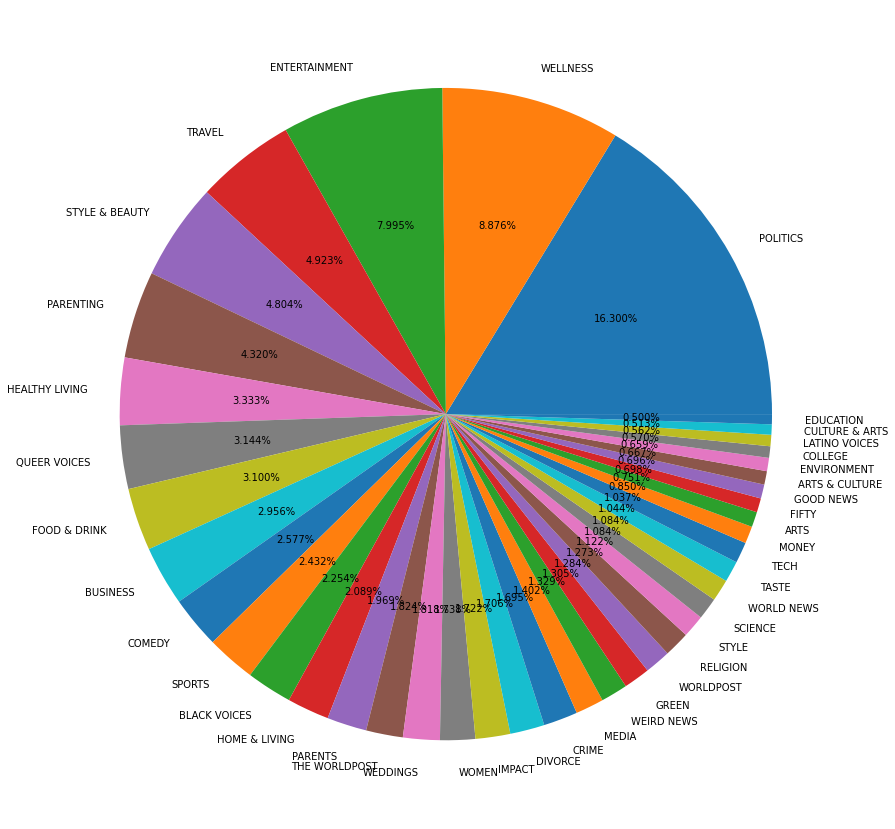

In [55]:
# Plotting category on piew chart
fig = plt.figure(figsize=(15,15))
plt.pie(df['category'].value_counts().values, labels=df['category'].value_counts().index, autopct='%1.3f%%');

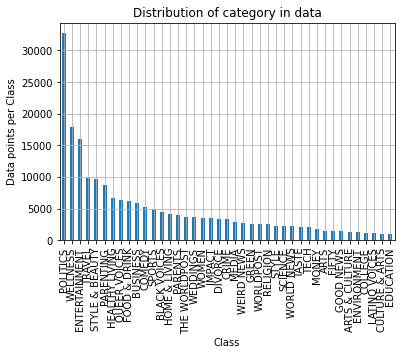

In [56]:
#plotting category on bar chart
category_distribution = df['category'].value_counts()
my_colors = 'rgbkymc'
category_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of category in data')
plt.grid()
plt.show()

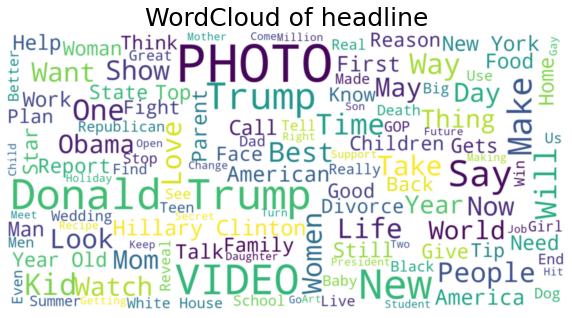

In [57]:
word_cloud = WordCloud(width=1600,height=800,margin=0,max_words=500, max_font_size=150, min_font_size=30, background_color="white").generate(" ".join(df['headline']))
plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('WordCloud of headline', fontsize = 25)
plt.axis("off")
plt.show()

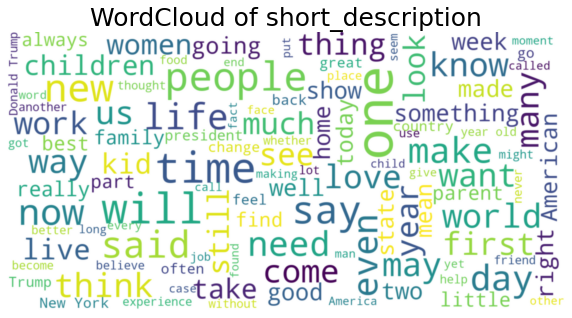

In [58]:
word_cloud = WordCloud(width=1600,height=800,margin=0,max_words=500, max_font_size=150, min_font_size=30, background_color="white").generate(" ".join(df['short_description']))
plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('WordCloud of short_description', fontsize = 25)
plt.axis("off")
plt.show()

<h3>3.1.3. Data Preprocessing</h3>

In [59]:
#Dropping date, link and authors columns as they may not be relevant in categorizing the news
#However, we can do some analysis between authors and category as some authors tend to write news on a particular category
#Dividing the date column into year and month , we can do some data analysis to find how year and month has impact on the number of news articles on a particular category
data = df.drop(['date','link','authors'],axis = 1).copy()
data.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


In [60]:
#Merging few categories as they tend to cater similar category of news
data['category'] = data['category'].map(lambda x: "WORLDPOST" if x == 'THE WORLDPOST' else x)
data['category'] = data['category'].map(lambda x: "EDUCATION" if x == 'COLLEGE' else x)
data['category'] = data['category'].map(lambda x: "ARTS & CULTURE" if x == 'ARTS' else x)
data['category'] = data['category'].map(lambda x: "PARENTING" if x == 'PARENTS' else x)
data['category'] = data['category'].map(lambda x: "FOOD & DRINK" if x == 'TASTE' else x)
data['category'] = data['category'].map(lambda x: "STYLE & BEAUTY" if x == 'STYLE' else x)
data['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
PARENTING         12632
STYLE & BEAUTY    11903
TRAVEL             9887
FOOD & DRINK       8322
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
ARTS & CULTURE     2848
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
SCIENCE            2178
WORLD NEWS         2177
EDUCATION          2148
TECH               2082
MONEY              1707
FIFTY              1401
GOOD NEWS          1398
ENVIRONMENT        1323
LATINO VOICES      1129
CULTURE & ARTS     1030
Name: category, dtype: int64

In [61]:
#Displaying number of null values in each column
for i in data.columns:
  print(i)
  print(len(data[data[i] == ""]))
  print("--------------------")

category
0
--------------------
headline
6
--------------------
short_description
19712
--------------------


In [62]:
#Deleting rows that have null values on both columns 
data = data[data['headline'] != ""]
data = data[data['short_description'] != ""]

In [63]:
for i in data.columns:
  print(i)
  print(len(data[data[i] == ""]))
  print("--------------------")

category
0
--------------------
headline
0
--------------------
short_description
0
--------------------


There are no null values in the data now

In [64]:
#Merging headline and short_description into news_desc column
data['news_desc']=data['headline'] + ' ' + data['short_description']
#Dropping headline and short_description columns
data = data.drop(['headline','short_description'],axis = 1).copy()
data.head()


,category,news_desc
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [65]:
#Sending the processed data to csv for further use
data.to_csv('news_processed.csv', columns=['category', 'news_desc'])

In [66]:
data = pd.read_csv("/content/news_processed.csv")
data.head()

,Unnamed: 0,category,news_desc
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [67]:
#Checking how many words are there in news_desc column
data['news_desc'].apply(lambda x: len(x.split(' '))).sum()

5701503

In [72]:
def text_preprocess(data,text):
  lemmatizer = WordNetLemmatizer()
  for i,row in data.iterrows():
      string = ''

      sentence = row[text]
      #sentence = expand_contractions(sentence)
      #sentence = spell_check(sentence)
      sentence = re.sub(r'[^\w\s]',' ',sentence)
      sentence = re.sub(r"\s+"," ", sentence, flags = re.I)#removing extra space
      sentence = re.sub(r"\d", " ", sentence)#removing digits
      sentence = re.sub(r"\s+[a-zA-Z]\s+", " ", sentence)#removing single characters
      sentence = re.sub(r"[,@\'?\.$%_]", "", sentence, flags=re.I)#removing multiple characters

        # replace every special char with space
      #sentence = re.sub('[^a-zA-Z0-9\n]', ' ', sentence)
        # replace multiple spaces with single space
      #sentence = re.sub('\s+',' ', sentence)
        # converting all the chars into lower-case.
      sentence = sentence.lower()

      words = nltk.word_tokenize(sentence)

      for word in words:
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                #string += word + " "
                string += str(lemmatizer.lemmatize(word)) + " "

      #words = [w for w in words if not w in stop_words]


      data.loc[i,text] = string
  return data

In [73]:
stop_words = stopwords.words('english')
#data['news_desc'] = data['news_desc'].apply(text_preprocess)
text_preprocess(data,'news_desc').head()
data.head()

,Unnamed: 0,category,news_desc
0,0,CRIME,mass shooting texas last week tv left husband ...
1,1,ENTERTAINMENT,smith join diplo nicky jam world cup official ...
2,2,ENTERTAINMENT,hugh grant marries first time age actor longti...
3,3,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...
4,4,ENTERTAINMENT,julianna margulies us donald trump poop bag pi...


In [74]:
data.to_csv('news_processed_lemma.csv', columns=['category', 'news_desc'])

In [3]:
data = pd.read_csv("/content/news_processed_lemma.csv")
data.head()

,Unnamed: 0,category,news_desc
0,0,CRIME,mass shooting texas last week tv left husband ...
1,1,ENTERTAINMENT,smith join diplo nicky jam world cup official ...
2,2,ENTERTAINMENT,hugh grant marries first time age actor longti...
3,3,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...
4,4,ENTERTAINMENT,julianna margulies us donald trump poop bag pi...


In [4]:
#Creating mapper dictionary to convert the categories into numerical values
mapper = {}
for i,categ in enumerate(data["category"].unique()):
        mapper[categ] = i
data["cat_class"] = data["category"].map(mapper)
data.head()


,Unnamed: 0,category,news_desc,cat_class
0,0,CRIME,mass shooting texas last week tv left husband ...,0
1,1,ENTERTAINMENT,smith join diplo nicky jam world cup official ...,1
2,2,ENTERTAINMENT,hugh grant marries first time age actor longti...,1
3,3,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,1
4,4,ENTERTAINMENT,julianna margulies us donald trump poop bag pi...,1


<h3>3.1.4. Test and Train split</h3>

In [5]:
from sklearn.model_selection import train_test_split
X = data.drop(['category','cat_class'], axis=1)
y = data['category']
# split the data into test and train by maintaining same distribution of varaible 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=123)
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 121363
Number of data points in test data: 59777


<h3>3.1.5. Featurizing data with BOW Vectorizer</h3>

In [6]:
#spacy.load("en")
#lemmatizer = spacy.lang.en.English()

#def my_preprocessor(text):
  #text = re.sub("[^a-zA-Z]", " ", text)
  #return(unescape(text).lower())
#def my_tokenizer(text):
  #tokens = lemmatizer(text)
  #return([token.lemma_ for token in tokens])

#vectorizer_news = CountVectorizer(min_df=0.01,max_df=0.95,ngram_range=(1,2))
vectorizer_news = CountVectorizer()
vectorizer_news.fit(X_train['news_desc'].values)

# using the fitted CountVectorizer to convert the text to vector
X_train_news_bow = vectorizer_news.transform(X_train['news_desc'].values)
X_test_news_bow = vectorizer_news.transform(X_test['news_desc'].values)

tokens = vectorizer_news.get_feature_names()
print("After vectorizations")
print(X_train_news_bow.shape, y_train.shape)
print(X_test_news_bow.shape, y_test.shape)
#print("="*100)
#df_vect = pd.DataFrame(data=X_train_news_bow.toarray(), columns=tokens)
#df_vect

After vectorizations
(121363, 62994) (121363,)
(59777, 62994) (59777,)


In [7]:
import pickle
# Downloading the CountVectorizer as pickle file
pickle.dump(X_train_news_bow, open("X_train_news_bow.pickle", "wb"))

<h3>3.1.6. Featurizing data with TfIdf Vectorizer</h3>

In [18]:
#vectorizer_idf_news = TfidfVectorizer(min_df=0.01,max_df=0.95,ngram_range=(1,2))
vectorizer_idf_news = TfidfVectorizer()
vectorizer_idf_news.fit(X_train['news_desc'].values)

# using the fitted TfIdfVectorizer to convert the text to vector
X_train_news_tfidf = vectorizer_idf_news.transform(X_train['news_desc'].values)
X_test_news_tfidf = vectorizer_idf_news.transform(X_test['news_desc'].values)

tokens_idf = vectorizer_idf_news.get_feature_names()
print("After vectorizations")
print(X_train_news_tfidf.shape, y_train.shape)
print(X_test_news_tfidf.shape, y_test.shape)

#print("="*100)
#df_idf_vect = pd.DataFrame(data=X_train_news_tfidf.toarray(), columns=tokens_idf)
#df_idf_vect

After vectorizations
(121363, 62994) (121363,)
(59777, 62994) (59777,)


In [24]:
# Downloading the TfIdfVectorizer as pickle file
pickle.dump(X_train_news_tfidf, open("X_train_news_tfidf.pkl", "wb"))

<h2>4.1. Machine Learning Models</h2>

<h3>4.1.1.1 Logistic Regression using Countvectorizer without hyper parameter tuning</h3>

In [19]:
Lg = LogisticRegression(max_iter = 1000).fit(X_train_news_bow,y_train)
X_test_news_bow = vectorizer_news.transform(X_test['news_desc'].values)
pred = Lg.predict(X_test_news_bow)
print(accuracy_score(y_test,pred))


0.6277330745939074


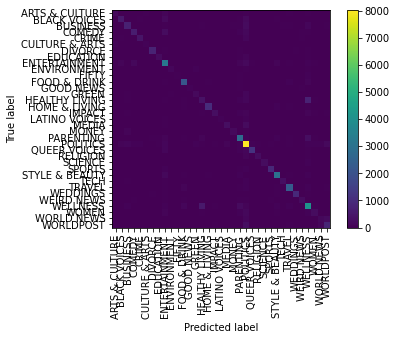

In [15]:
plot_confusion_matrix(Lg, X_test_news_bow, y_test,xticks_rotation='vertical',include_values=False)

<h3>4.1.1.2 Logistic Regression using TfIdfvectorizer without hyper parameter tuning</h3>

In [22]:
Lg = LogisticRegression(max_iter = 1000).fit(X_train_news_tfidf,y_train)
X_test_news_tfidf = vectorizer_news.transform(X_test['news_desc'].values)
pred = Lg.predict(X_test_news_tfidf)
print(accuracy_score(y_test,pred))

0.6188166017029961


In [23]:
pickle.dump(Lg,open("LR_model.pkl","wb"))

<h3>4.1.2.1 Multinomial Naive Bayes using TfIdfvectorizer without hyper parameter tuning</h3>

In [21]:
mnb = MultinomialNB().fit(X_train_news_tfidf,y_train)
X_test_news_tfidf = vectorizer_news.transform(X_test['news_desc'].values)
pred = mnb.predict(X_test_news_tfidf)
print(accuracy_score(y_test,pred))

0.4967796978771099


LR gave good accuracy than MNB

<h3>4.1.2.2 Multinomial Naive Bayes with hyper parameter tuning</h3>

In [ ]:
train_auc = []
cv_auc = []
#params ={"alpha": [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
params ={"alpha": [0.05,0.01,0.1,0.5,1,5,10,50,100]}

mnb_clf = MultinomialNB()
mnb_grid = GridSearchCV(mnb_clf, param_grid=params, n_jobs=-1, cv=3, return_train_score=True)
mnb_grid.fit(X_train_news_bow.todense(),y_train)

results = pd.DataFrame.from_dict(mnb_grid.cv_results_)

results = results.sort_values(['param_alpha'])

train_auc = results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']
alpha = list(alpha)
print(alpha)
alpha = [math.log(x) for x in alpha]


plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")

plt.grid()
plt.show()

results.head()

In [ ]:
best_alpha=10
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

mnb_clf = MultinomialNB(alpha=best_alpha)
#mnb_clf.fit(X_train_news_bow.todense(),y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
sig_clf = CalibratedClassifierCV(mnb_clf, method="sigmoid")
sig_clf.fit(X_train_news_bow.todense(), y_train)
sig_clf_probs = sig_clf.predict_proba(X_test_news_bow.todense())
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(y_test, sig_clf_probs))
#print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test_news_bow.todense())-y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, sig_clf.predict(X_test_news_bow.todense()))



Log Loss : 2.356186719278213


NameError: ignored

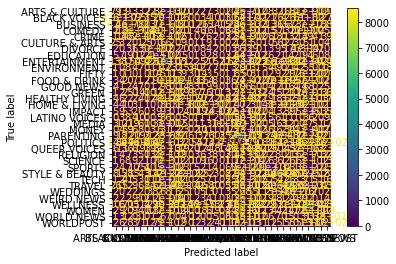

In [ ]:
#plot_confusion_matrix(y_test, sig_clf.predict(X_test_news_bow.todense()))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(sig_clf, X_test_news_bow.todense(), y_test)